# Muller-Brown experiments

# Import

In [3]:
import re

In [4]:
import torch
import lightning
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [9]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [10]:
# Set seed for reproducibility
torch.manual_seed(42);

In [12]:
import sys

In [ ]:
# NOTE: adjust if you cloned these elsewhere
sys.path.append("src/DistributionalPrincipalAutoencoder")
sys.path.append("src/engression")
sys.path.append("src/mlcolvar")

In [17]:
from mlcolvar.utils.io import create_dataset_from_files
from mlcolvar.data import DictModule

In [18]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from mlcolvar.utils.trainer import MetricsCallback

In [21]:
from dpa.dpa_fit import DPA

In [22]:
from mlcolvar.cvs import VariationalAutoEncoderCV

In [23]:
from utils.plot_utils import muller_brown_potential, plot_isolines_2D, plot_gradient_2D

## Plot setup

In [24]:
import matplotlib as mpl

plt.style.use('default')
mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['savefig.dpi'] = 200
mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 16
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['contour.linewidth'] = 1.5
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['axes.grid'] = False
mpl.rcParams['grid.alpha'] = 0.3
mpl.rcParams['grid.linewidth'] = 1
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.framealpha'] = 1.0
mpl.rcParams['legend.edgecolor'] = 'black'
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.pad_inches'] = 0.1

# Load MD data

In [ ]:
# NOTE: this is bundled with mlcolvar
# filenames = ["src/mlcolvar/docs/notebooks/tutorials/data/muller-brown/unbiased/high-temp/COLVAR"]
# NOTE: providing a local copy
filenames = ["data/COLVAR"]

dataset, df = create_dataset_from_files(filenames, filter_args={'regex': 'p.x|p.y'}, return_dataframe=True)

In [ ]:
n_input = 2

In [27]:
datamodule = DictModule(dataset,
                        lengths=[0.8, 0.2],
                        random_split=True
                        )

In [38]:
X = dataset[:]['data'].to(device)

# Adapters

For VAE:

In [40]:
class ForwardCVModule(torch.nn.Module):
    def __init__(self, vae_cv: VariationalAutoEncoderCV):
        super(ForwardCVModule, self).__init__()
        self.norm_in = vae_cv.norm_in
        self.encoder = vae_cv.encoder
        self.mean_nn = vae_cv.mean_nn

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.norm_in is not None:
            x = self.norm_in(x)
        x = self.encoder(x)
        return self.mean_nn(x)

For DPA

In [41]:
class EncoderModule(torch.nn.Module):
    def __init__(self, trained_model, standardize=False, x_mean=None, x_std=None):
        super(EncoderModule, self).__init__()
        self.trained_model = trained_model
        self.trained_model.raw = trained_model.model
        self.encoder = self.trained_model.model.encoder
        self.standardize = self.trained_model.standardize
        self.x_mean = self.trained_model.x_mean
        self.x_std = self.trained_model.x_std
        self.device = next(self.encoder.parameters()).device

    def forward(self, x, k=None, mean=True, gen_sample_size=100):
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32, requires_grad=True)
        x = x.to(self.device)

        if not x.requires_grad:
            x.requires_grad_(True)

        if self.standardize:
            x = (x - self.x_mean.to(self.device)) / self.x_std.to(self.device)

        if k is None:
            k = self.trained_model.latent_dim
        if self.trained_model.encoder_k:
            x = self.trained_model.get_k_embedding(k, x)

        z = self.encoder(x)
        return z[:, :k]

In [42]:
def extract_first_numbers_after_epoch(filename):
    with open(filename, 'r') as file:
        text = file.read()

    pattern = r'\[Epoch (\d+)\]\s+([\d.]+)'
    matches = re.findall(pattern, text)
    numbers = np.array([(float(m1), float(m2)) for m1, m2 in matches])
    return numbers

# $\beta=2$ model

In [49]:
n_feats = X.shape[1]
k = 3
num_layer = 4
hidden_dim = 100
latent_dims = list(range(k + 1))[::-1]


In [50]:
prefix = f"res/models/MB/{k}k{num_layer}l{hidden_dim}h/"

In [51]:
dpaModelBeta2 = DPA(
    beta=2,
    dist_enc="deterministic",
    dist_dec="stochastic",
    data_dim=n_input,
    latent_dims=latent_dims,
    num_layer=num_layer,
    hidden_dim=hidden_dim,
    noise_dim=100,
    resblock=True,
    standardize=False,
    device=device,
    seed=42
)


GPU is available, running on GPU.



In [ ]:
dpaModelBeta2.train(X,
                    batch_size=X.shape[0] // 3 + 1,
                    num_epochs=2000,
                    lr=5e-4,
                    save_model_every=100,
                    save_dir=prefix,
                    save_loss=True,
                    )

# Plot

In [44]:
from utils.mfep_utils import string_method

In [47]:
minima = [(-0.558, 1.442), (-0.050, 0.467), (0.623, 0.028)]

In [ ]:
# Calculate MFEP between minima
path1 = string_method(minima[0], minima[1], n_points=250)
path2 = string_method(minima[1], minima[2], n_points=100)

In [ ]:
mfep_xy = np.concatenate([path1, path2])

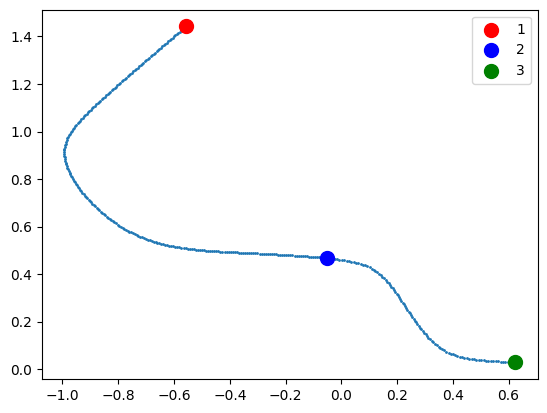

In [321]:
plt.scatter(mfep_xy[:, 0], mfep_xy[:, 1], s=1);
plt.scatter(minima[0][0], minima[0][1], c="red", s=100, label="1");
plt.scatter(minima[1][0], minima[1][1], c="blue", s=100, label="2");
plt.scatter(minima[2][0], minima[2][1], c="green", s=100, label="3");
plt.legend();


In [ ]:
np.save("res/aux/MB/mfep_xy.npy", mfep_xy)

Plot

In [227]:
dpaModelBeta2.model.load_state_dict(torch.load(f"{prefix}/model_{1800}.pt"))
dpaModelBeta2.model = dpaModelBeta2.model.to(device)
dpaModelBeta2.model.eval();
dpaeFuncBeta2 = EncoderModule(dpaModelBeta2)

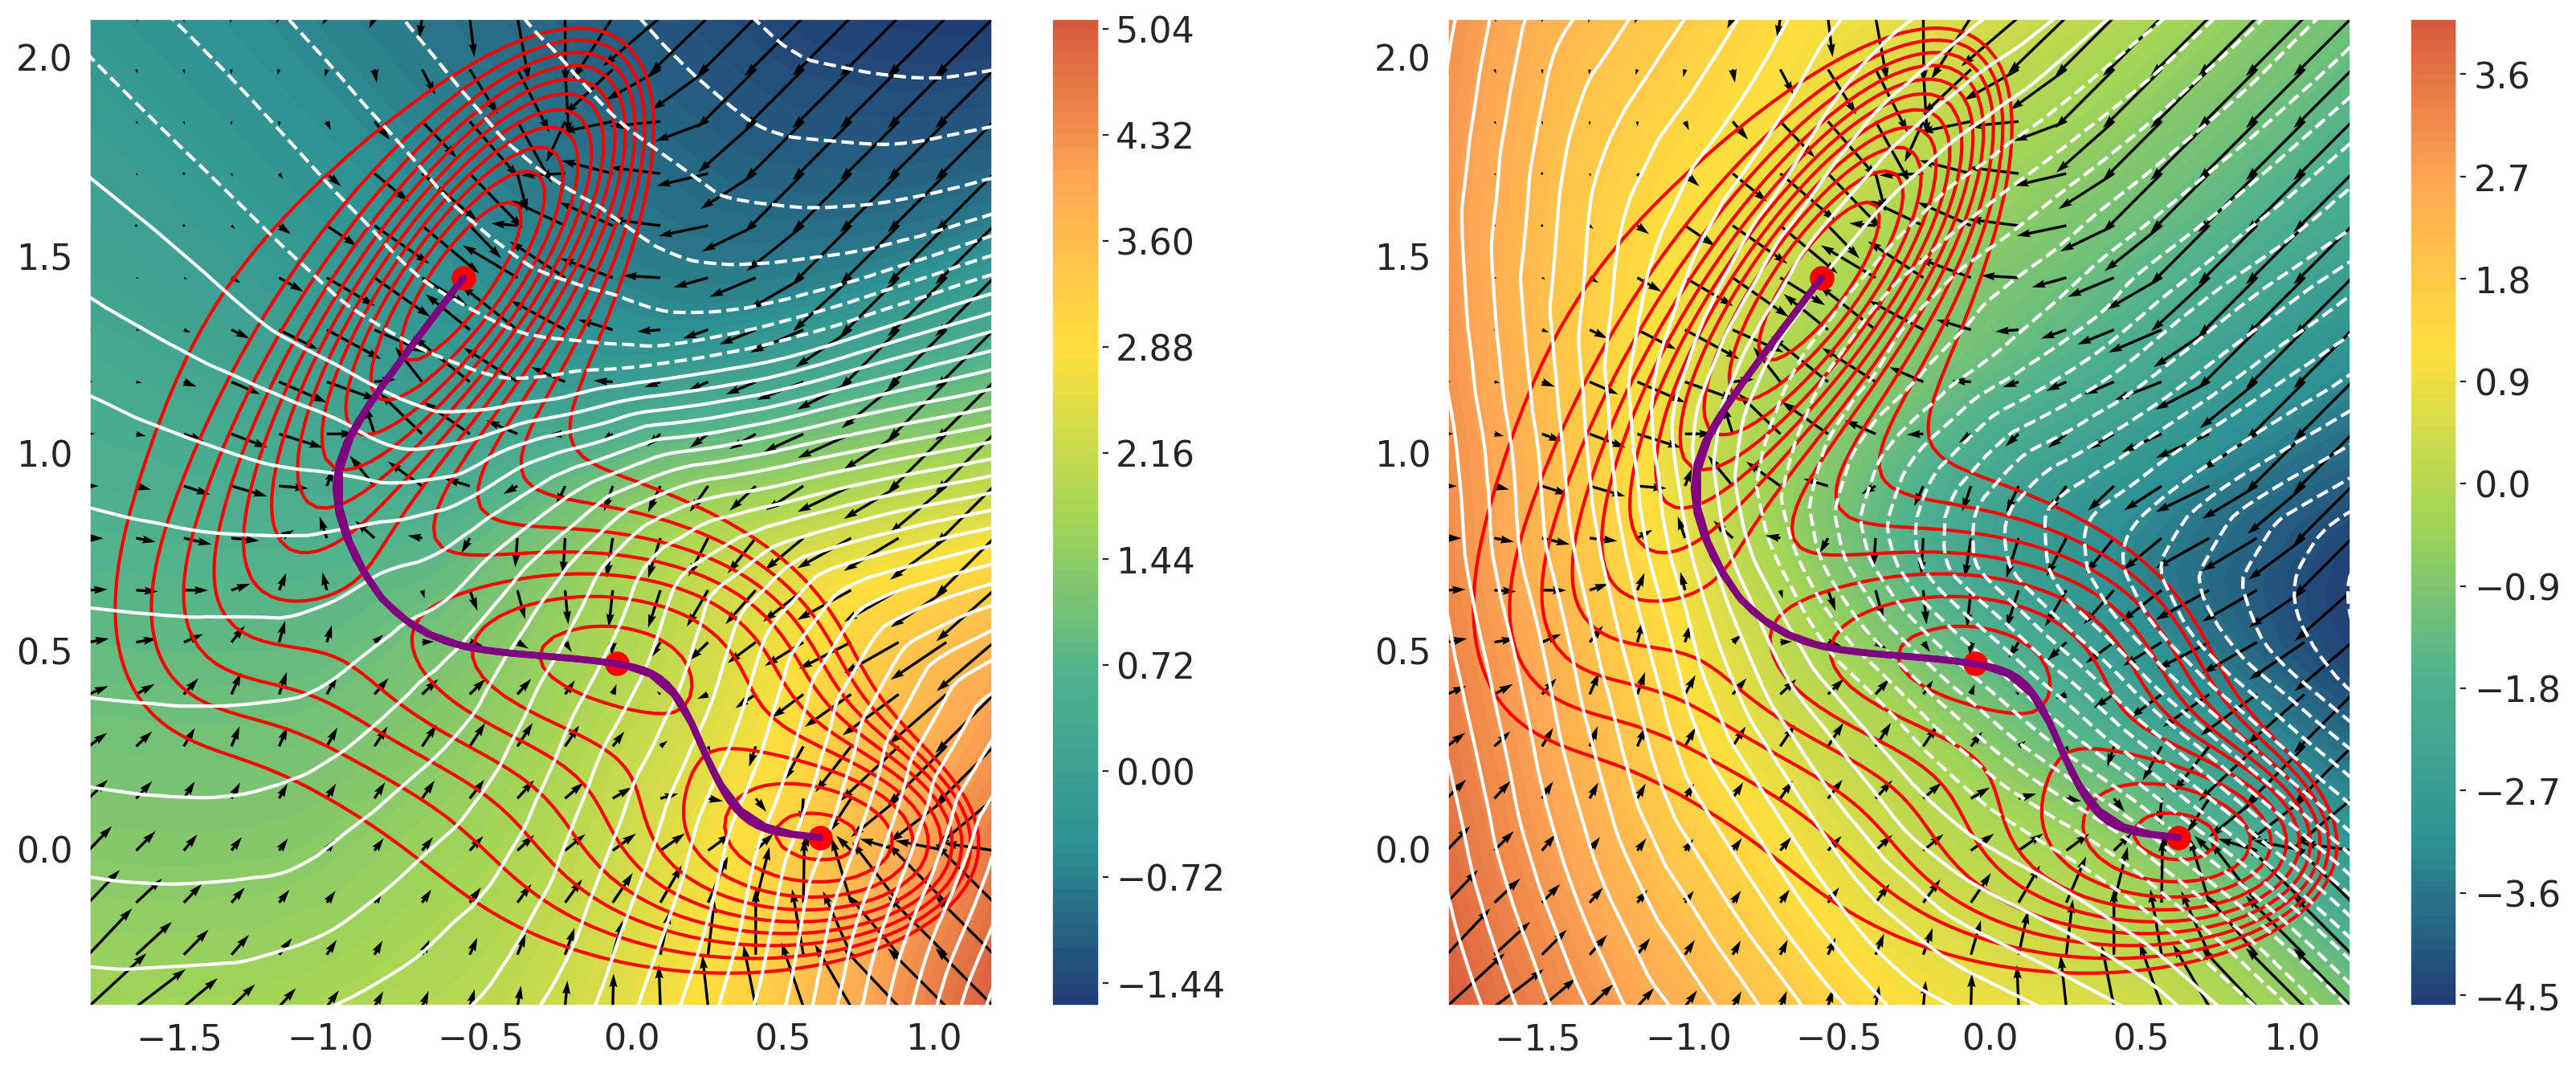

In [79]:
n_components = 2
fig, axs = plt.subplots(1, n_components, figsize=(10 * n_components, 8))

for i in range(n_components):
    ax = axs[i]
    plot_isolines_2D(muller_brown_potential, levels=np.linspace(0, 24, 12), mode='contour', ax=ax,
                     colors="red")
    plot_isolines_2D(dpaeFuncBeta2, component=i, levels=100, ax=ax)
    plot_isolines_2D(dpaeFuncBeta2, component=i, mode='contour', levels=40, ax=ax,
                     colors="w")

    plot_gradient_2D(lambda x, y: -1. * muller_brown_potential(x, y), num_points=(20, 20), ax=ax, clip_grad=50,
                     color="k",
                     scale=300, scale_units='xy');

    ax.plot(*zip(*minima), 'ro', markersize=10)

    ax.plot(path1[:, 0], path1[:, 1], color='purple', linewidth=3, label='MFEP')
    ax.plot(path2[:, 0], path2[:, 1], color='purple', linewidth=3, label='MFEP 2-3')



# Compare with AE, VAE

In [54]:
from mlcolvar.cvs import AutoEncoderCV

In [55]:
encoder_layers = [n_input, 10, 10, n_components]
nn_args = {'activation': 'shifted_softplus'}
options = {'encoder': nn_args, 'decoder': nn_args}

In [56]:
modelAE = AutoEncoderCV(encoder_layers, options=options)

In [ ]:
metricsAE = MetricsCallback()
early_stoppingAE = EarlyStopping(monitor="valid_loss", min_delta=1e-5, patience=10)

trainerAE = lightning.Trainer(callbacks=[metricsAE, early_stoppingAE],
                              max_epochs=None,
                              logger=None,
                              enable_checkpointing=False,
                              enable_progress_bar=False,
                              enable_model_summary=False,
                              log_every_n_steps=0,
                              )

In [ ]:
trainerAE.fit(modelAE, datamodule)

In [59]:
torch.save(modelAE, "res/models/MB/ae/MB_AE_new.pkl")

In [62]:
modelAE = torch.load("res/models/MB/ae/MB_AE_new.pkl").to(device)

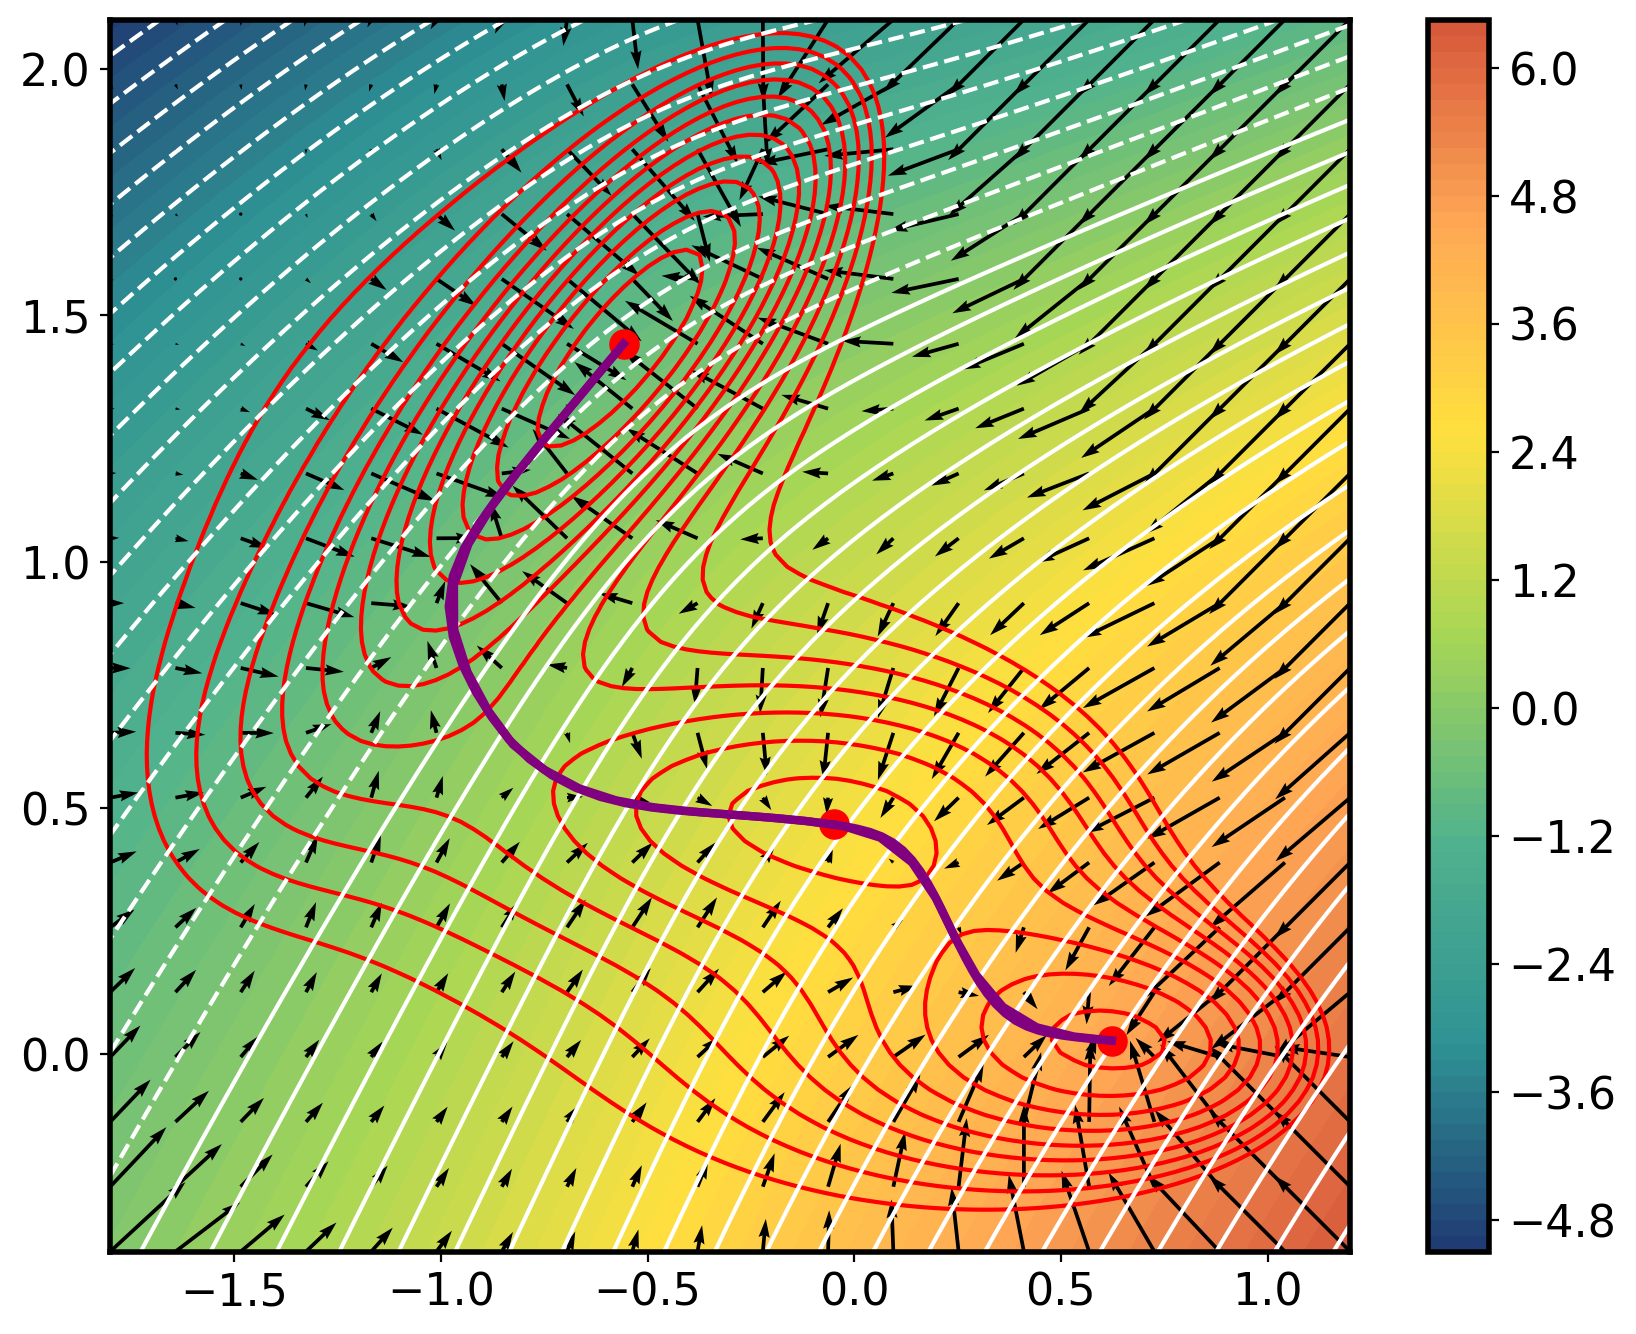

In [186]:
n_components = 1
fig, axs = plt.subplots(1, n_components, figsize=(10 * n_components, 8))

for i in range(n_components):
    ax = axs[i] if (n_components > 1) else axs
    plot_isolines_2D(muller_brown_potential, levels=np.linspace(0, 24, 12), mode='contour', ax=ax,
                     colors="red")
    plot_isolines_2D(modelAE.to("cpu"), component=i, levels=100, ax=ax)
    plot_isolines_2D(modelAE, component=i, mode='contour', levels=40, ax=ax,
                     colors="w")

    plot_gradient_2D(lambda x, y: -1. * muller_brown_potential(x, y), num_points=(20, 20), ax=ax, clip_grad=50,
                     color="k",
                     scale=300, scale_units='xy');

    ax.plot(*zip(*minima), 'ro', markersize=10)

    ax.plot(path1[:, 0], path1[:, 1], color='purple', linewidth=3, label='MFEP')
    ax.plot(path2[:, 0], path2[:, 1], color='purple', linewidth=3, label='MFEP 2-3')



In [65]:
from mlcolvar.cvs import VariationalAutoEncoderCV

In [71]:
n_components = 2
encoder_layers = [n_input, 10, 10]
nn_args = {'activation': 'elu'}
options = {'encoder': nn_args, 'decoder': nn_args}

In [72]:
modelVAE = VariationalAutoEncoderCV(n_cvs=n_components, encoder_layers=encoder_layers,
                                    options=options).to(device)


In [ ]:
metricsVAE = MetricsCallback()
early_stoppingVAE = EarlyStopping(monitor="valid_loss", min_delta=1e-6, patience=20)

trainerVAE = lightning.Trainer(callbacks=[metricsVAE, early_stoppingVAE],
                               max_epochs=None,
                               logger=None,
                               enable_checkpointing=False,
                               enable_progress_bar=False,
                               enable_model_summary=False,
                               log_every_n_steps=0,
                               )

In [ ]:
trainerVAE.fit(modelVAE, datamodule)

In [181]:
torch.save(modelVAE, f"res/models/MB/vae/MB_VAE_new.pkl")

In [73]:
modelVAE = torch.load(f"res/models/MB/vae/MB_VAE_new.pkl")

In [74]:
vaeFunc = ForwardCVModule(modelVAE.to(device))

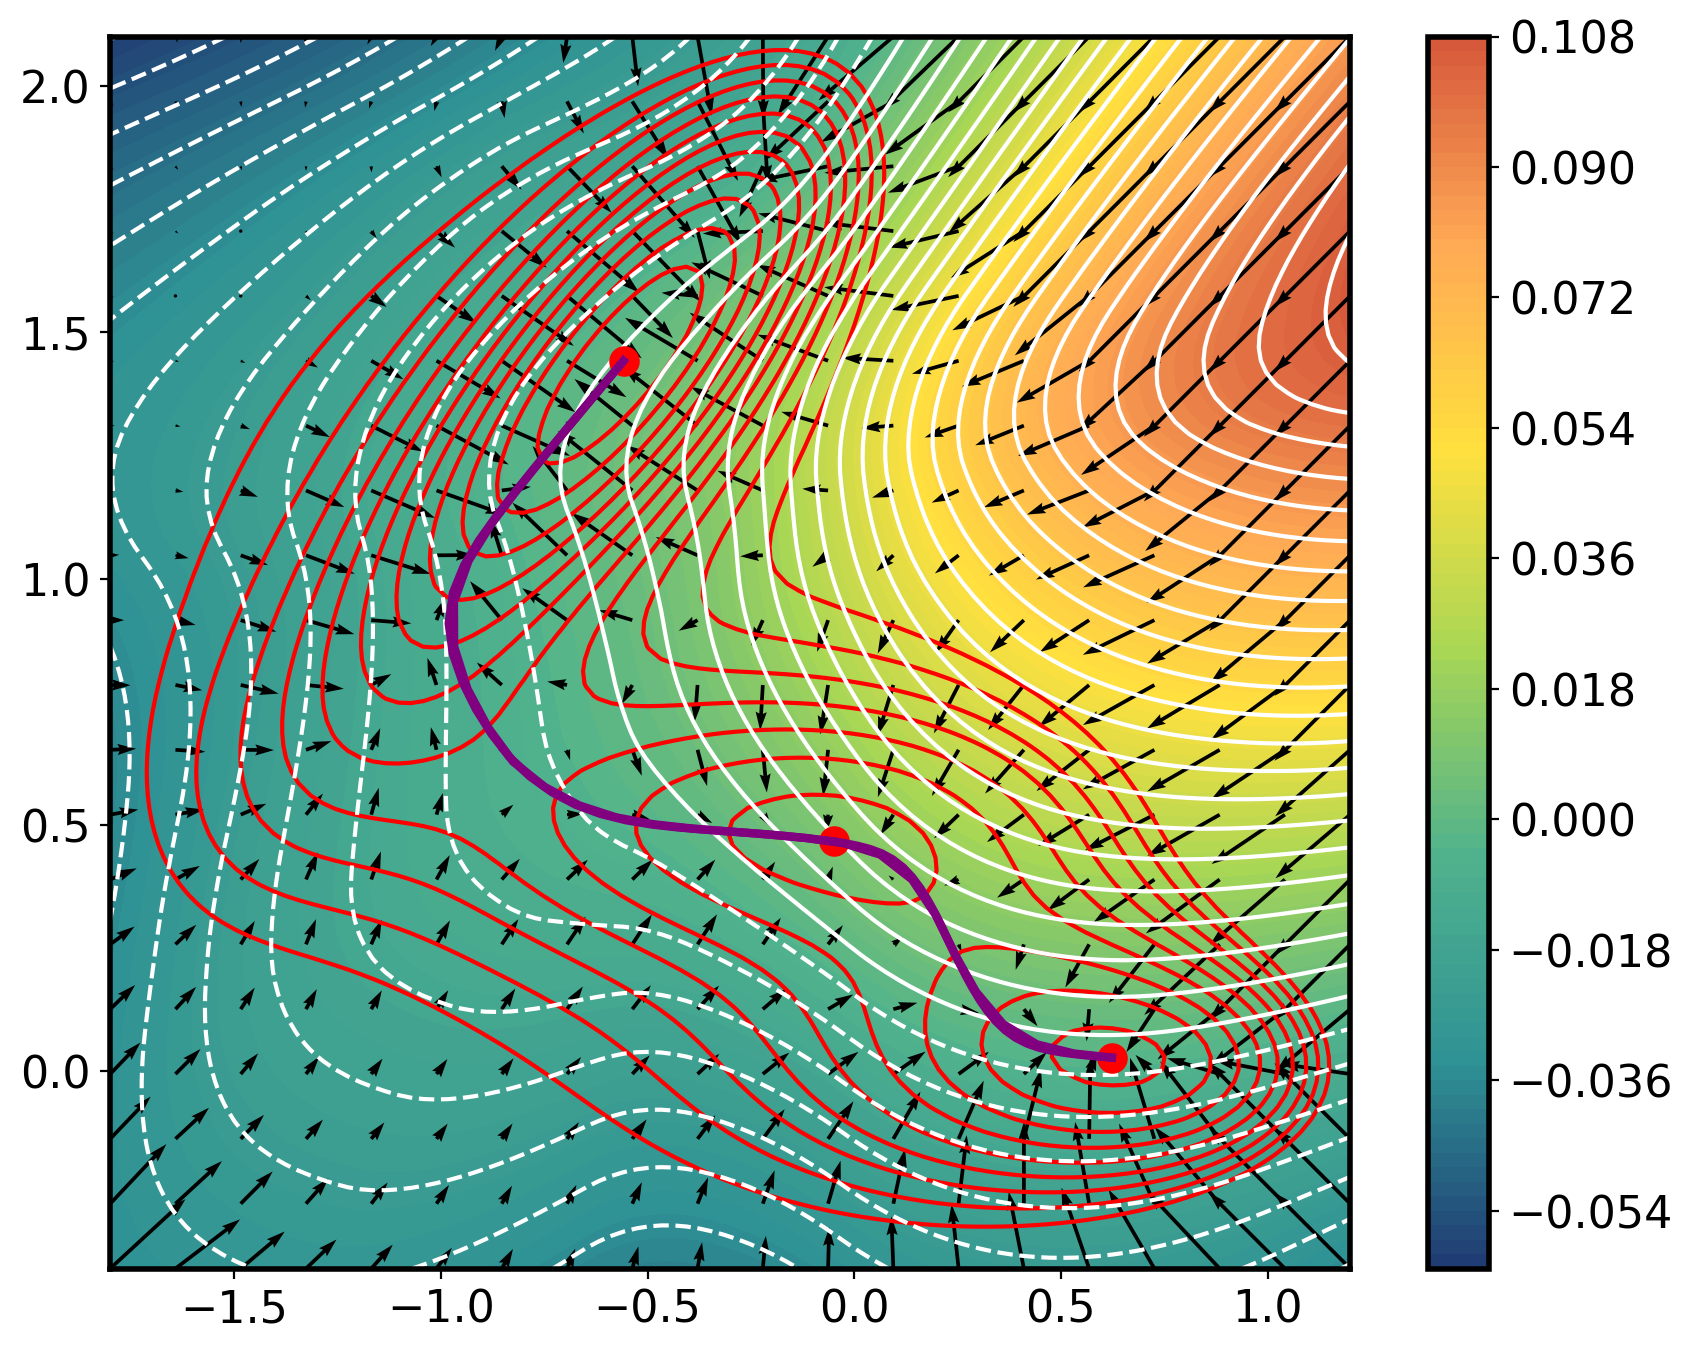

In [187]:
n_components = 1
fig, axs = plt.subplots(1, n_components, figsize=(10 * n_components, 8))

for i in range(n_components):
    ax = axs[i] if (n_components > 1) else axs
    plot_isolines_2D(muller_brown_potential, levels=np.linspace(0, 24, 12), mode='contour', ax=ax,
                     colors="red")
    plot_isolines_2D(vaeFunc.to("cpu"), component=i, levels=100, ax=ax)
    plot_isolines_2D(vaeFunc, component=i, mode='contour', levels=40, ax=ax,
                     colors="w")

    plot_gradient_2D(lambda x, y: -1. * muller_brown_potential(x, y), num_points=(20, 20), ax=ax, clip_grad=50,
                     color="k",
                     scale=300, scale_units='xy');

    ax.plot(*zip(*minima), 'ro', markersize=10)

    ax.plot(path1[:, 0], path1[:, 1], color='purple', linewidth=3, label='MFEP')
    ax.plot(path2[:, 0], path2[:, 1], color='purple', linewidth=3, label='MFEP 2-3')
